# Nearest Training Image

Una manera con la cual se evaluó una posible memorización de ejemplos de entrenamientos por parte del generador fue utilizar la red lensfinder replicada para obtener un vector de activaciones del conjunto de entrenamiento, para ser comparadas con el vector de activaciones de las imágenes generadas.

In [1]:
import sys
from pathlib import Path

# Agregar la carpeta src al Path para poder cargar los métodos y clases necesarias.
# También agregamos la carpeta data.
src_path = str(Path.cwd().parents[0] / "src")

if src_path not in sys.path:
    sys.path.append(src_path)   

In [2]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
import numpy as np
import pandas as pd
from keras.models import Model, load_model
from keras import backend as K
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

from experiments import (
    read_experiment_dataset,
    get_nearest_images,
    plot_pairs_of_images
)

Using TensorFlow backend.


## Leer datasets

In [4]:
df_space = pd.read_csv(
    '../data/space_based_data/SpaceBasedTraining/classifications.csv',
    sep=','
)
df_space = df_space.astype({'ID':int})

try:
    dict_data = np.load('../data/space_based_data/space_lens_images.npz')
    # extract the first array
    lens_images = dict_data['arr_0']
except:
    path_space_based = '../data/space_based_data/SpaceBasedTraining/Public/Band1/'
    lens_images = read_space_lens_images(
        path_space_based,
        df_space,
        lens_label=1
    )
    np.savez_compressed('../data/space_based_data/space_lens_images.npz', lens_images)

In [5]:
synthetic_images, df_synthetic_lens = read_experiment_dataset('../data/experiments/50_epochs_100_images')

## Obtener imágenes más cercanas

In [6]:
def preprocess_images(images):
    MEAN = 4.3368545e-13 #precalculated from training dataset
    STD = 5.5039e-12 #precalculated from training dataset
    images[images == 100] = 0.0
    return (images - MEAN) / STD

In [7]:
lens_images = preprocess_images(lens_images)
synthetic_images = preprocess_images(synthetic_images)

In [8]:
#Read classifier model
def custom_relu(x):
    relu = K.relu(x)
    return (relu - 0.3989422804014327) * 1.712858550449663

lensfinder_model = load_model('../models/lensfinder/lensfinder_model_val_loss_0.25.hdf5',custom_objects={'custom_relu': custom_relu})
lensfinder_model = Model(inputs=lensfinder_model.inputs, outputs=lensfinder_model.layers[-2].output)

In [9]:
pairs_of_images = get_nearest_images(
    synthetic_images,
    lens_images,
    lensfinder_model,
    euclidean_distances
)

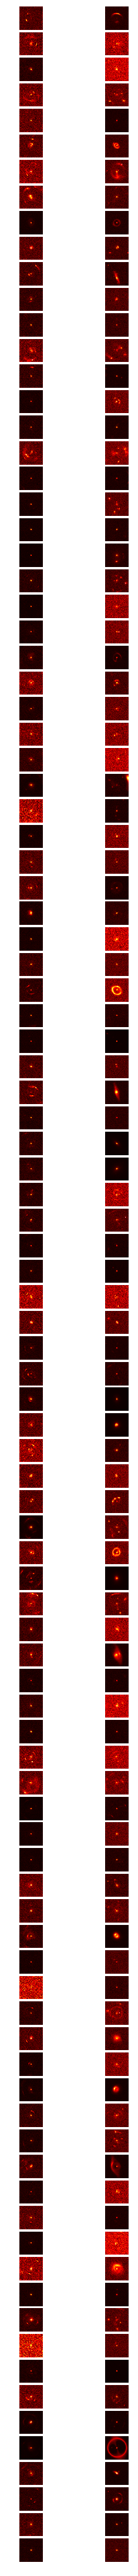

In [10]:
plot_pairs_of_images(pairs_of_images,'../reports/figures/nearest_images.png')